In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
import matplotlib
import sklearn
import matplotlib.pyplot as plt
import mglearn
import seaborn as sns
from mglearn import plot_knn_classification
sns.set()
%matplotlib inline

# Import & Process Data

In [2]:
# Import Dataset
adult = pd.read_csv("https://raw.githubusercontent.com/sauchilee/Stat517/master/Data/adult_preprocessed.csv")
# Define feature headers
Features = adult.dtypes.index
# Define feature headers for X
X_features = Features.drop('salary')
# Convert data to matrix for processing
data = np.matrix(adult)

In [3]:
# Change Categroical data to dummy variable 0 and 1
y = []
count1 = 0
count0 = 0
for i in range(len(data)):
    y.append(data[i,97])
for i in range(len(y)):
    if y[i] == '<=50K':
        y[i]= 0
        count0 = count0+1
    if y[i] == '>50K':
        y[i]= 1
        count1 = count1+1

# Create sub-datasets for X(features) and y(target)  
X = pd.DataFrame(data[:,:97], columns = X_features)
y = pd.DataFrame(y, columns = ['salary'])

# Split into training and testing (default: 75%, 25%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Model Evaluations
- K-Nearest Neighbor
- Logistic Regression
- Naive Bayes
- Decision Tree
- Gradient Boosting Classifier
- Support Vector Machine

## K - Nearest Neighbors

Summary of model:

K - Nearest Neighbor models work by plotting the testing data along side the known training data. The alogorithm finds the n nearest points and assigns the majority class to the data point with the unkown target. This is how the salary class is predicted for this dataset. 

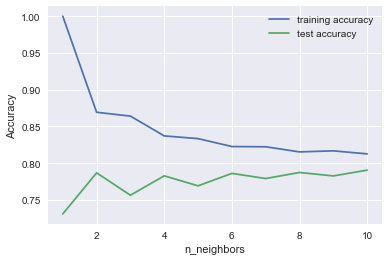

In [4]:
from sklearn.neighbors import KNeighborsClassifier

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, np.ravel(y_train))
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, np.ravel(y_train)))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, np.ravel(y_test)))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

From the plot of n_neighbors vs accuracy it can be seen that the best choice for the number of neighbors is between 6 and 8. I chose n = 8 to gain a littler high accuracy in the testing set. 

Training set accuracy: 0.82
Test set accuracy: 0.79
AUC for KNN: 0.598


Text(0,0.5,'TPR (recall)')

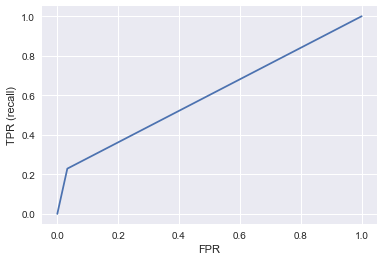

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Fit KNN model to training data
clf = KNeighborsClassifier(n_neighbors=8)
clf.fit(X_train, np.ravel(y_train))
# ROC curve and AUC metrics
fpr, tpr, thresholds = roc_curve(y_test, clf.predict(X_test))

# Define Model Metrics on training and testing data
KNNtra = clf.score(X_train, np.ravel(y_train))
KNNtea = clf.score(X_test, np.ravel(y_test))
KNNauc = roc_auc_score(y_test, clf.predict(X_test))

# Print model metrics
print("Training set accuracy: {:.2f}".format(clf.score(X_train, np.ravel(y_train))))
print("Test set accuracy: {:.2f}".format(clf.score(X_test, np.ravel(y_test))))
print("AUC for KNN: {:.3f}".format(KNNauc))

# Plot TPR versus FPR for every threshold
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

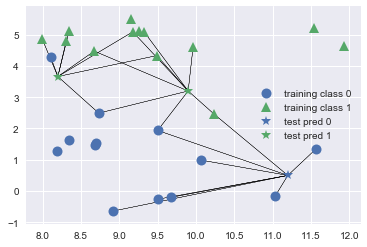

In [6]:
mglearn.plots.plot_knn_classification(n_neighbors=8)

Results:

The testing and training accuracy of this model is around 80% which at first appears to be moderately high. Upon further inspection from the AUC metric, it can be shown that in reality this model is nbarely better than a coin toss. 

Model Pros & Cons:

This low AUC score is most likely due to the slight imbalance in the data where only about 25% of the samples had a salary greater than 50k. In cases such as these, if the model simply predicts 0 100% of the time we will see a 75% testing accuracy rate. For this reason, a K-NN model would not be a good choice for this dataset. 

## Logistic Regression

Summary of model:

Logistic regression models the probability that Y belongs to a particular class. For this dataset, logistic regression will model the probability of having a salary greater than 50k given the sociodemographic data. Logistic regression differd from linear regression in that it is bounded by 0 and 1 by an exponential fucntion:

$$ log[p(X)/(1 -p(X)] = A + BX $$

Where A and B are the regression coefficients. 

Training accuracy of l1 logreg with C=0.001: 0.81
Test accuracy of l1 logreg with C=0.001: 0.80
Training accuracy of l1 logreg with C=1.000: 0.85
Test accuracy of l1 logreg with C=1.000: 0.85
Training accuracy of l1 logreg with C=100.000: 0.85
Test accuracy of l1 logreg with C=100.000: 0.85


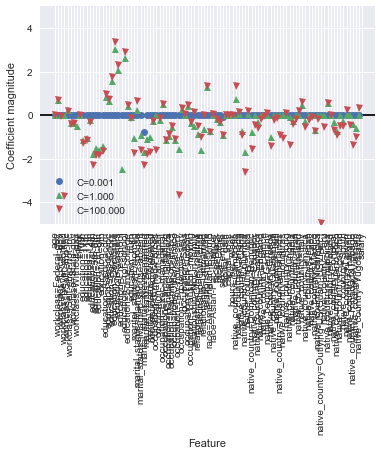

In [7]:
from sklearn.linear_model import LogisticRegression

# Choosing hyperparameter C
for C, marker in zip([0.001, 1, 100], ['o', '^', 'v']):
    lr_l1 = LogisticRegression(C=C, penalty="l1").fit(X_train, np.ravel(y_train))
    print("Training accuracy of l1 logreg with C={:.3f}: {:.2f}".format(
          C, lr_l1.score(X_train, np.ravel(y_train))))
    print("Test accuracy of l1 logreg with C={:.3f}: {:.2f}".format(
          C, lr_l1.score(X_test, np.ravel(y_test))))
    plt.plot(lr_l1.coef_.T, marker, label="C={:.3f}".format(C))

plt.xticks(range(data.shape[1]),Features, rotation=90)
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.ylim(-5, 5)
plt.legend(loc=3)

The plot above shows how different shrink values impact the 85 features. It can be seen from this that the green distribution (C = 1) is a good middle ground between total shrink (Coefficient = 0) and total chaos at C = 100. For further inspection, we will see how the testing and training accuracies differ at different C values in the next block. 

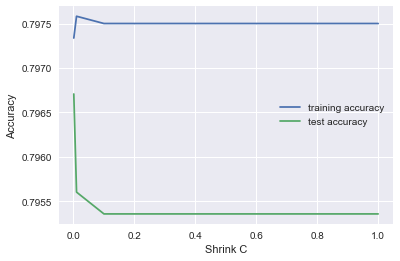

In [8]:
training_accuracy = []
test_accuracy = []
# try C from 0.0001 to 100
C = [0.001, 0.01, 0.1, 1]
for C in C:
    # build the model
    logreg = LogisticRegression(C=C).fit(X_train, np.ravel(y_train))
    # record training set accuracy
    training_accuracy.append(logreg.score(X_train, np.ravel(y_train)))
    # record generalization accuracy
    test_accuracy.append(logreg.score(X_test, np.ravel(y_test)))

C = [0.001, 0.01, 0.1,1]
plt.plot(C, training_accuracy, label="training accuracy")
plt.plot(C, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Shrink C")
plt.legend()

Upon further inspection of the hyperparameter it appears that the C value does not impact the model accuracy too mcuh. Becuase of this, a shrink value of 1 will be used for building the model. 

Logreg: Training set score: 0.798
Logreg: Test set score: 0.795
AUC for logreg: 0.573


Text(0,0.5,'TPR (recall)')

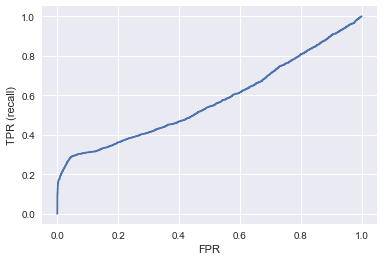

In [9]:
# Build model and prediction
logreg = LogisticRegression(C=1).fit(X_train, np.ravel(y_train))
pred_logreg = logreg.predict(X_test)
# Compute Area Under Curve (AUC)
fpr, tpr, thresholds = roc_curve(np.ravel(y_test), logreg.decision_function(X_test))

# Define model metrics
LRtra = logreg.score(X_train, np.ravel(y_train))
LRtea = logreg.score(X_test, np.ravel(y_test))
LRauc = roc_auc_score(np.ravel(y_test), logreg.decision_function(X_test))

#Print  model metrics
print("Logreg: Training set score: {:.3f}".format(logreg.score(X_train, np.ravel(y_train))))
print("Logreg: Test set score: {:.3f}".format(logreg.score(X_test, np.ravel(y_test))))
print("AUC for logreg: {:.3f}".format(LRauc))

# Plot TPR versus FPR for every threshold
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

Results:

The results of this model appeared to be satisfactory from the testing and training accuracy score of about 80%. Though similarly to the KNN model,the AUC value is not impressive and indicates the FPR and TPR are nearly equal. 

Model Pros & Cons:

The advantage of Logisitic Regression is that it's output is a probability and can be used for ranking as well as classifying.  

## Naive Bayes

Summary of model:

The Naive Bayes model works by modeling the distribution of each predictor X for each class of y and then uses Bayes Theorem to convert the ditribution into a probability using the equation below:

$$ [f(X | y)f(y)] /  f(X) $$

NB: Training set score: 0.795
NB: Test set score: 0.795
AUC for NB: 0.632


Text(0,0.5,'TPR (recall)')

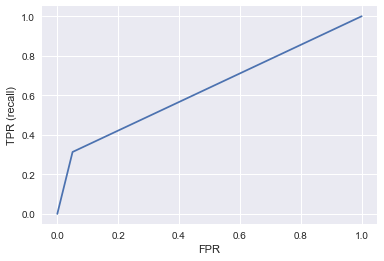

In [10]:
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(X_train, np.ravel(y_train));
NB_predict = NB.predict(X_test)
# Compute AUC
fpr, tpr, thresholds = roc_curve(np.ravel(y_test), NB.predict(X_test))
NB_auc = roc_auc_score(np.ravel(y_test), NB.predict(X_test))

# Define model metrics
NBtra = NB.score(X_train, np.ravel(y_train))
NBtea = NB.score(X_test, np.ravel(y_test))
NBauc = NB_auc

# Print model metrics
print("NB: Training set score: {:.3f}".format(NB.score(X_train, y_train)))
print("NB: Test set score: {:.3f}".format(NB.score(X_test, y_test)))
print("AUC for NB: {:.3f}".format(NB_auc))

# Plot TPR versus FPR for every threshold
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

Results:

The results of this model are similar to those of Logistic Regression and K-NN. The model training and testing accuracy are high but the AUC is low.

Model Pros & Cons:

Bayes theorem assumes a normal gaussian distribution and that all predictors are independent. These assumptions and simplifications might not be applicable to this dataset which could be the source of the error in the model as suggested by the ROC curve. 

## Decision Tree

Summary of model:

Decision tree models work by prediciting a response for an observation that belongs to the most commonly occuring class of training observations in it's region. It then repeats this for a specified depth until a stopping criterion is reached. 

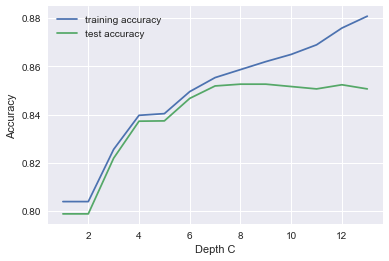

In [11]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

# Tune hyperparameter max depth
training_accuracy = []
test_accuracy = []

D = np.arange(1,14,1)
for D in D:
    # build the model
    tree = DecisionTreeClassifier(max_depth=D, random_state=0)
    tree.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(tree.score(X_train, np.ravel(y_train)))
    # record generalization accuracy
    test_accuracy.append(tree.score(X_test, np.ravel(y_test)))
    # record AUC
    tree_auc = roc_auc_score(np.ravel(y_test), tree.predict(X_test))
    
D = np.arange(1,14,1)
plt.plot(D, training_accuracy, label="training accuracy")
plt.plot(D, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Depth C")
plt.legend()

Plotting the accuracy versus the max depth hyperparameter will help tune the model. From this plot, a depth = 6 will result in the best testing and training accuracy without risk of overfitting. 

In [12]:
tree = DecisionTreeClassifier(max_depth=6, random_state=0)
tree.fit(X_train, y_train)
fpr, tpr, thresholds = roc_curve(np.ravel(y_test), tree.predict(X_test))
tree_auc = roc_auc_score(np.ravel(y_test), tree.predict(X_test))

Accuracy on training set: 0.850
Accuracy on test set: 0.847
AUC for treee: 0.749


Text(0,0.5,'TPR (recall)')

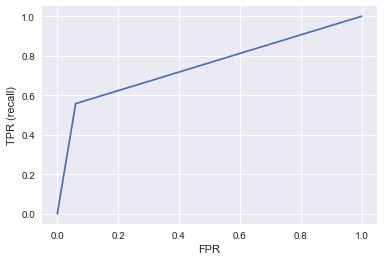

In [13]:
Treetra = tree.score(X_train, np.ravel(y_train))
Treetea = tree.score(X_test, np.ravel(y_test))
Treeauc = roc_auc_score(np.ravel(y_test), tree.predict(X_test))

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))
print("AUC for treee: {:.3f}".format(Treeauc))

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

Text(0,0.5,'Feature')

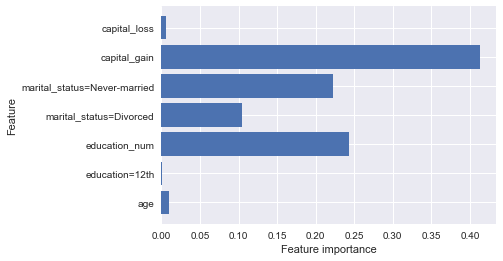

In [14]:
# Evaluate the important features that contribute to salary
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X, y)
important_X = tree.feature_importances_

# Loop through the selected features, if the feature is deemed important (value > 0.01),
# create a new list of important features (Factors) and record their labels(Factor_labels)
Factors = []
Factor_labels = []
indice_important = []
for i in range(len(important_X)):
    if important_X[i] > 0:
        Factors.append(important_X[i])
        Factor_labels.append(X_features[i])
        # column indice of important feature
        indice_important.append(i)
        
# Graphically display the condensed list of the most important features
# in determing a salary greater than 50K.

n_features = Factor_labels
plt.barh(n_features, Factors, align='center')
plt.xlabel("Feature importance")
plt.ylabel("Feature")

A helpful tool when using the Decison Tree model is that it can determine which features are most influential in predicting the target. The graph above shows a condensed version of all predicitors that had a coefficient score greater than 0. From this it can be seen that Capital Gain, Marital Status and education most greatly impact the Purhcase class when using this Decision Tree model with a hyperparameter of D = 6. 

Results:

The results of this tree model are more promising than previous models. All three metrics suggest a moderately effective model with an AUC score of 0.75. This indicates that the model had a significantly larger TPR than FPR. 

Model Pros & Cons:

Trees are great for simplicity and graphical displays of the dataset, but are very senstive to small changes in the data. One way to increase the performance of a tree is to apply the gradient booster, which will be modeled in the next section. 

## Gradient Boosting Classifier

Summary of model:

Boosting a decision tree model is done by growing trees based on information from the previous tree. Boosting builds trees on a modified version of the original dataset, it does not use bootstrapping like other decision tree models. 

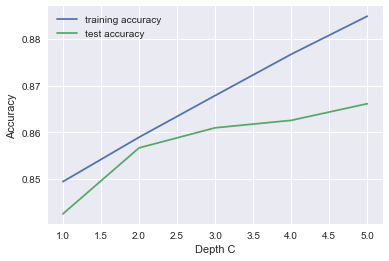

In [24]:
#Output graph of important features
from sklearn.ensemble import GradientBoostingClassifier

# Tune depth hyperparameter
training_accuracy = []
test_accuracy = []

D = np.arange(1,6,1)
for D in D:
    # build the model
    gbrt = GradientBoostingClassifier(random_state=0, max_depth=D)
    gbrt.fit(X_train, np.ravel(y_train))
    # record training set accuracy
    training_accuracy.append(gbrt.score(X_train, np.ravel(y_train)))
    # record generalization accuracy
    test_accuracy.append(gbrt.score(X_test, np.ravel(y_test)))
    # record AUC
    fpr, tpr, thresholds = roc_curve(np.ravel(y_test), gbrt.decision_function(X_test))
    gbrt_auc = roc_auc_score(np.ravel(y_test), gbrt.decision_function(X_test))
    

D = np.arange(1,6,1)
plt.plot(D, training_accuracy, label="training accuracy")
plt.plot(D, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Depth C")
plt.legend()

It can be shown from the plot above that using a max depth hyperparameter of 3 will result in the greatest test accuracy without over fitting the data. 

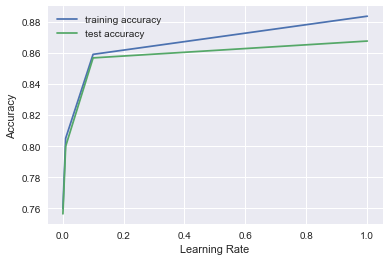

In [16]:
# Tune learning rate hyperparameter
training_accuracy = []
test_accuracy = []

rate = [0.001,0.01,0.1,1]
for rate in rate:
    # build the model
    gbrt = GradientBoostingClassifier(random_state=0, max_depth = 2, learning_rate=rate)
    gbrt.fit(X_train, np.ravel(y_train))
    # record training set accuracy
    training_accuracy.append(gbrt.score(X_train, np.ravel(y_train)))
    # record generalization accuracy
    test_accuracy.append(gbrt.score(X_test, np.ravel(y_test)))
    # record AUC
    fpr, tpr, thresholds = roc_curve(np.ravel(y_test), gbrt.decision_function(X_test))
    gbrt_auc = roc_auc_score(np.ravel(y_test), gbrt.decision_function(X_test))
    

rate = [0.001,0.01,0.1,1]
plt.plot(rate, training_accuracy, label="training accuracy")
plt.plot(rate, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Learning Rate")
plt.legend()

The plot above shows how the rate at which the model learns impacts the accuarcy. Using a learning rate of 0.1 will result in the greatest testing accuracy which is a typical value for boosted classifiers. The learning rate will be set at it's default value of 0.1 and a d = 2 will be used. 

Accuracy on training set: 0.859
Accuracy on test set: 0.857
AUC for gbrt: 0.911


Text(0,0.5,'TPR (recall)')

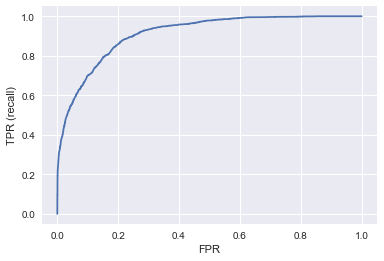

In [17]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth = 2)
gbrt.fit(X_train, np.ravel(y_train))
fpr, tpr, thresholds = roc_curve(np.ravel(y_test), gbrt.decision_function(X_test))
gbrt_auc = roc_auc_score(np.ravel(y_test), gbrt.decision_function(X_test))

GBtra = gbrt.score(X_train, np.ravel(y_train))
GBtea = gbrt.score(X_test, np.ravel(y_test))
GBauc = gbrt_auc

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, np.ravel(y_train))))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, np.ravel(y_test))))
print("AUC for gbrt: {:.3f}".format(gbrt_auc))

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

Results:

The results of the gradient boosting classifier model are quite impressive. The model has a high accuracy rate in both training and testing data and the AUC score validates that it is an effective model for this data set. The AUC score indicates that the true positive rate is much greater than the false positive rate, meaning the model predicts correctly a majority of the time.

Model Pros & Cons:

The advantages of using the gradient booster is that it makes the decision tree methodology more robust, which holds true in comparing the two models on this dataset. Additionally, becuase boosting takes into account the prior trees when creating new tress, it often can outperform random forests with a shallower depth parameter. Conversly, the disadvantages of using this kind of model is that it often is computationally more expensive due to it's greater learning capacity. 

## Support Vector Classifier

Summary of model:

Support vector machines work by creating a linear boundary or margine between like clusters, and penalizing observations that cross these boundaries using a hyperparameter C. 

Accuracy on training set: 0.97
Accuracy on test set: 0.75
AUC for svc: 0.629


Text(0,0.5,'TPR (recall)')

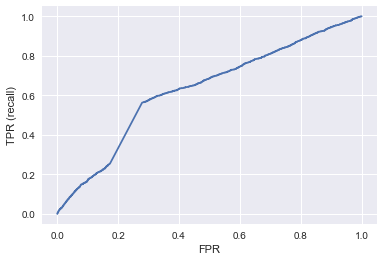

In [18]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, np.ravel(y_train))
fpr, tpr, thresholds = roc_curve(np.ravel(y_test), svc.decision_function(X_test))
svc_auc = roc_auc_score(np.ravel(y_test), svc.decision_function(X_test))


SVCtra = svc.score(X_train, np.ravel(y_train))
SVCtea = svc.score(X_test, np.ravel(y_test))
SVCauc = svc_auc

print("Accuracy on training set: {:.2f}".format(svc.score(X_train, np.ravel(y_train))))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, np.ravel(y_test))))
print("AUC for svc: {:.3f}".format(svc_auc))

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

Results:

The results of this model are not promising. The testing accuarcy is moderate and the AUC is in the lower range indicating that the model predicts wrongly quite often. 

Model Pros & Cons:

One disadvantage of SVC models is that they separate the data with a linear boundary, unlike Support Vector Machines which separate with non-linear boundaries. This makes SVM more robust for a wider range of datasets. 

## Summary of Model Results

In [25]:
KNN = [KNNtra, KNNtea, KNNauc,]
LR = [LRtra,LRtea,LRauc]
NB = [NBtra,NBtea,NBauc]
Tree = [Treetra,Treetea,Treeauc]
GB = [GBtra,GBtea,GBauc]
SVC = [SVCtra,SVCtea,SVCauc]

Train = [KNNtra,LRtra,NBtra,Treetra,GBtra,SVCtra]
Test = [KNNtea,LRtea,NBtea,Treetea,GBtea,SVCtea]
AUC = [KNNauc,LRauc,NBauc,Treeauc,GBauc,SVCauc]

data = [KNN , LR, NB, Tree, GB, SVC]
Table = pd.DataFrame({'Train': Train, 'Test': Test, 'AUC': AUC}, 
                     columns=['Train', 'Test','AUC'], 
                     index = ['K-NN','Log Reg','Naive Bayes','Decision Tree', 'Grad. Boost.', 'SVC'] )
Table

,Train,Test,AUC
K-NN,0.815397,0.787373,0.598051
Log Reg,0.797502,0.795357,0.572771
Naive Bayes,0.794676,0.794865,0.631575
Decision Tree,0.849509,0.846702,0.748811
Grad. Boost.,0.865606,0.856652,0.911119
SVC,0.968796,0.751136,0.629034


From the metrics table, it can be seen that the Gradient Boosting Classifier model performs the best becasue it has the largest AUC value. This will be the model applied to the data to asses what factors influence salaries over 50k. 

In [26]:
# Fit gbrt model on the entire dataset
gbrt = GradientBoostingClassifier(random_state=0, max_depth = 3)
gbrt_pred = gbrt.fit(X, np.ravel(y))
GBtra = gbrt.score(X, np.ravel(y))
GBauc = gbrt_auc

print("Accuracy of model on dataset: {:.3f}".format(gbrt.score(X, np.ravel(y))))
print("AUC for gbrt: {:.3f}".format(GBauc))

Accuracy of model on dataset: 0.866
AUC for gbrt: 0.925


Text(0,0.5,'Feature')

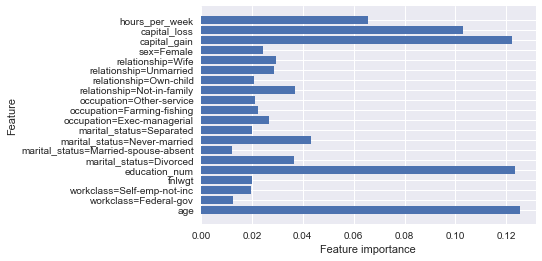

In [21]:
# Evaluate the important features that contribute to salary
important_X = gbrt.feature_importances_

# Loop through the selected features, if the feature is deemed important (value > 0.01),
# create a new list of important features (Factors) and record their labels(Factor_labels)
Factors = []
Factor_labels = []
indice_important = []
for i in range(len(important_X)):
    if important_X[i] > 0.01:
        Factors.append(important_X[i])
        Factor_labels.append(X_features[i])
        # column indice of important feature
        indice_important.append(i)
        
# Graphically display the condensed list of the most important features
# in determing a salary greater than 50K.

n_features = Factor_labels
plt.barh(n_features, Factors, align='center')
plt.xlabel("Feature importance")
plt.ylabel("Feature")

The important features from the gradient boosting classifier model are shown in the graph above. This is a condensed version where only the features with an importance greater than 0.01 are shown. It can be seen from this that the major features that influence whether or not a customer purchases car insurance are:
- Age
- Education
- Capital Gain and Loss
- Hours worked per week
- Marital Status
- Occupation type




# Modeling Critique

The six models outlined in this project showed varying results on the Adult.csv dataset. The models were all optimized by intelligently selecting the appropriate hyperparameters, and their performance was assessed by use of ROC curves and AUC scores. I think there is room for improvement in the data visualization. Additionally, more models such as Random Forest and Nuerel Networks could have been assessed but due to computation time I chose to omit some models. Overall I think the final model selected perfomred very well with a test accuracy of 93% and an AUC of 0.91, which is approaching the realm of perfection. This model provided a comprehensive list of factors that most influence an individual's salary being above or below 50k. 